I changed the sign of the z and this seems to be working, I'm not sure why but it does.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

In [2]:
def standardize_cols(X):
    zscore = lambda x: (x.mean() - x)/x.std()
    return pd.DataFrame(X).apply(zscore).values

def binarize_cols(X):
    temp = X.copy()
    temp[temp > 0] = 1
    temp[temp <= 0] = 0
    return temp

In [3]:
spam_data = scipy.io.loadmat("data/spam.mat")
Xraw = pd.DataFrame(spam_data['Xtrain'])
y = spam_data['Ytrain'].reshape((3450,))
Xtestraw = pd.DataFrame(spam_data['Xtest'])

stan_X = pd.DataFrame(standardize_cols(Xraw.values))
log_X = pd.DataFrame(np.log(Xraw.values + 0.1))
bin_X = pd.DataFrame(binarize_cols(Xraw.values))
stan_X[57] = 1
log_X[57] = 1
bin_X[57] = 1
Xraw[57] = 1
X = Xraw.values
stan_X = stan_X.values
log_X = log_X.values
bin_X = bin_X.values
print(X.shape, stan_X.shape, log_X.shape, bin_X.shape)

(3450, 57) (3450,) (1151, 57)
(3450, 58) (3450, 58) (3450, 58) (3450, 58)


In [34]:
from random import shuffle

def quadratic_kernel(xi, xj):
    return np.power((np.dot(xi, xj) + 1), 2)

def quadratic_kernel_f(xi, X, alphai):
    for xj in X:
        yield alphai * quadratic_kernel(xi, xj)

def quadratic_kernel_ridge_sgd(xi, yi, alphai, X, y, gamma, lr):
    fxs = list(quadratic_kernel_f(xi, X, alphai))
    fx = np.sum(fxs)
    
    z = yi * fx
    sz = 1 / (1 + np.exp(-z))

    
    new_alpha = alphai - ((gamma * alphai) + (lr * sz * yi))

    
    loss = np.log(1 + np.exp(z)) # I changed the loss sign...
    
 #   print("loss:" , loss)
    return new_alpha, loss

def qkrsgd_wrapper(X, y, gamma, lr, num_iters):
    shuff = list(range(len(X)))
    shuffle(shuff)
    alpha = np.zeros(len(X))
    X = X[shuff]
    y = y[shuff]
    risks = []
    for upper_count in range(num_iters):
        temp_risk = []
        for count, (xi, yi, alphai) in enumerate(zip(X, y, alpha)):

            
            
            new_alpha, loss = quadratic_kernel_ridge_sgd(xi, yi, alphai, X, y, gamma, lr)
            
            
            alpha[count] = new_alpha
            alpha[count+1:] -= (alpha[count+1:] * gamma)
            alpha[:count] -= (alpha[:count] * gamma)
            temp_risk.append(loss)
        risks.append(np.sum(temp_risk))
    return alpha, pd.DataFrame({"risk":risks})

In [139]:
from random import shuffle

def log_func(x):
    return 1 / (1 + np.exp(-x))

def quadratic_kernel_ridge_sgd(xi, yi, alphai, X, y, gamma, lr):
    fx = np.sum(alphai * np.power((np.dot(xi, X.T) + 1), 2))
    z = yi * fx
    sz = 1 / (1 + np.exp(-z))
    new_alpha = alphai - ((gamma * alphai) + (lr * sz * yi))
    loss = np.log(1 + np.exp(z))
    return new_alpha, loss

def qkrsgd_train(X, y, alpha, gamma, lr):
    temp_risk = []
    for count, (xi, yi, alphai) in enumerate(zip(X, y, alpha)):
        new_alpha, loss = quadratic_kernel_ridge_sgd(xi, yi, alphai, X, y, gamma, lr)
        alpha[count] = new_alpha
        alpha[count+1:] -= (alpha[count+1:] * gamma)
        alpha[:count] -= (alpha[:count] * gamma)
        temp_risk.append(loss)
    return alpha, temp_risk

def qkrsgd_test(X, y, alpha):
    val_risk = []
    for count, (xi, yi, alphai) in enumerate(zip(X, y, alpha)):
        fx = np.sum(alphai * np.power((np.dot(xi, X.T) + 1), 2))
        z = yi * fx
        loss = np.log(1 + np.exp(z)) 
        val_risk.append(loss)
    return np.sum(val_risk)
    
    
def qkrsgd_wrapper(X, y, gamma, lr, num_iters):
    np.random.seed(20)
    shuff = list(range(len(X)))
    shuffle(shuff)
    X = X[shuff]
    y = y[shuff]
    traX, tray = X[:2500], y[:2500]
    valX, valy = X[2500:], y[2500:]
    alpha = np.zeros(len(traX))
    risks = []
    val_risks = []
    for upper_count in range(num_iters):
        #lr = 0.000001 / (1 + upper_count) # remove this to get the graph I sent to John
        alpha, temp_risk = qkrsgd_train(traX, tray, alpha, gamma, lr)
        risks.append(np.sum(temp_risk))
        val_risk = qkrsgd_test(valX, valy, alpha)
        val_risks.append(val_risk)
    return alpha, pd.DataFrame({
            "training risk":risks,
            "validation risk": val_risks
        })

In [140]:
tx,ty = stan_X[:500], y[:500]
tx,ty = stan_X, y

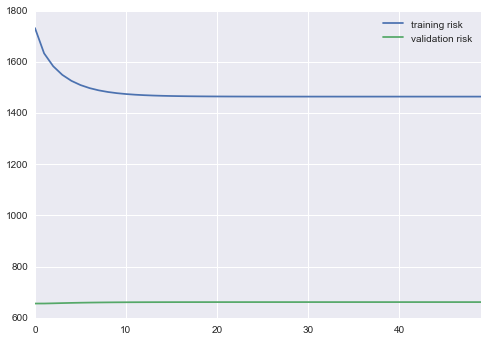

In [142]:
w2, risks = qkrsgd_wrapper(tx, ty, 10e-5, 0.000001, 50)
risks.plot()

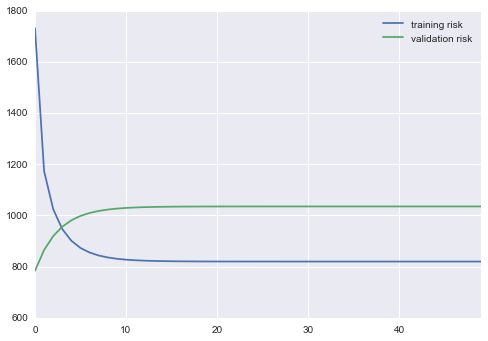

In [143]:
w2, risks = qkrsgd_wrapper(tx, ty, 10e-5, 0.00001, 50)
risks.plot()

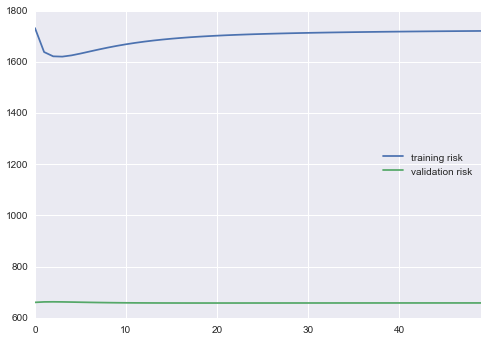

In [136]:
w2, risks = qkrsgd_wrapper(tx, ty, 10e-5, 0.00001, 50) 
# this is the auto learning rate
# seems to converge really fast then bounce out
risks.plot()